In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from FlagEmbedding import FlagModel
import base64
from openai import OpenAI
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="Represent this sentence for searching relevant passages: ",
                  use_fp16=True)

### Run this once to set your API key as an environment variable
import os

os.environ['OPENAI_API_KEY'] = 'your-openai-key'

In [125]:
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

In [102]:
def cosine_similarity(vec1, vec2):
    # Compute the dot product of vec1 and vec2
    dot_product = np.dot(vec1, vec2)
    
    # Compute the L2 norm of vec1 and vec2
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Compute the cosine similarity
    similarity = dot_product / (norm_vec1 * norm_vec2)
    
    return similarity

In [61]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
}

client = OpenAI()

def question_image(url,query):
    if url.startswith("http://")or url.startswith("https://"):
        response = client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=[
            {
            "role": "user",
            "content": [
                {"type": "text", "text": f"{query}"},
                    {
                    "type": "image_url",
                    "image_url": url,
                    },
                ],
            }
        ],
        max_tokens=1000,
            
        )
        return response.choices[0].message.content
    else:
        
        base64_image = encode_image(url)

        payload = {
            "model": "gpt-4-vision-preview",
            "messages": [
              {
                "role": "user",
                "content": [
                  {
                    "type": "text",
                    "text": f"{query}?"
                  },
                  {
                    "type": "image_url",
                    "image_url": {
                      "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                  }
                ]
              }
            ],
            "max_tokens": 1000
        }

        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

        temp=response.json()
        return temp['choices'][0]['message']['content']

In [ ]:
data=pd.read_excel(r"image_search_dataset.xlsx")

In [ ]:
data['imageDescription']=None

In [ ]:
query="Describe this image to me in detail"
for i,row in data.iterrows():
    url=row['imageUrl']
    try:
        response = requests.get(url)
        if response.status_code == 200:
            desc=question_image(url,query)
            data.at[i,'imageDescription']=desc
            data.to_excel(r"image_search_dataset.xlsx",index=False)
    except requests.exceptions.RequestException:
        continue

In [228]:
data['embedding']=None
for i,row in data.iterrows():
    temp=row['skuName']+row['imageDescription']+row['skuDescription']
    data.at[i,'embedding']=model.encode(temp)

In [252]:
data[['skuName','skuDescription','imageUrl']].head()

,skuName,skuDescription,imageUrl
0,100 Pipers Scotch Whiskey 100 CL,"Our 100 Pipers Whisky has been distilled, aged...",https://sa.adanione.com/-/media/Foundation/Ada...
1,A*Men Eau De Toilette Spray 100ml,A*Men is a manifestation of the contemporary h...,https://sa.adanione.com/-/media/Foundation/Ada...
2,A*Men Pure Mal Eau De Toilette Spray 100ml,"Enhanced by ageing in oak casks, A*Men takes o...",https://sa.adanione.com/-/media/Foundation/Ada...
3,Aberfeldy 12 YO 100cl,"A fruity, clean and polished malt with a touch...",https://sa.adanione.com/-/media/Foundation/Ada...
4,Aberlour 12YO Double Cask 100cl,The 12 year-old expression is a fine example o...,https://sa.adanione.com/-/media/Foundation/Ada...


In [268]:
def top_5_products(user_input):
    user_embedding=model.encode(user_input)
    data['scores']=None
    for i,row in data.iterrows():
        data.at[i,'scores']=cosine_similarity(user_embedding,row['embedding'])
    data['scores'] = pd.to_numeric(data['scores'], errors='coerce')
    top_5=data.nlargest(5,'scores')
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Create 1 row with 5 columns for images
    for i, row in enumerate(top_5.iterrows()):
        image = load_image(row[1]['imageUrl'])
        axs[i].imshow(np.array(image))
        axs[i].set_title(f"{row[1]['skuName']}")
    plt.show()
    print(top_5['scores'][:5])

### Search by product name or type:
"100 Pipers Scotch Whiskey"
"Aberfeldy 12 Year Old"
"Aberlour Double Cask 12 Year Old"

### Search by description:
"Scotch whiskey aged and mellowed"
"Eau de toilette spray for men"
"Fruity, clean, and polished malt"

### Search by visual description:
"Bottle of Seagram's 100 Pipers"
"Tall cylindrical bottle with a deep blue color"
"Aberlour Single Malt with a gold seal"

### Search by sensory or unique characteristics:
"Whiskey with a smoky flavor"
"Perfume with a metallic note"
"Single malt with a sherry cask finish"

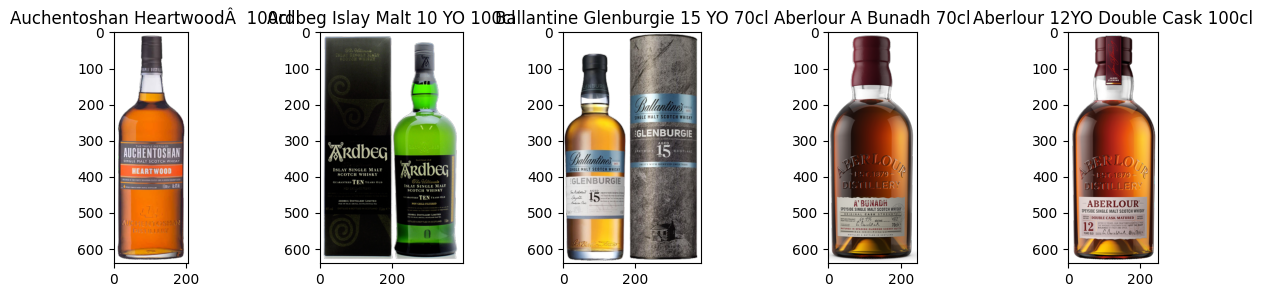

38    0.752787
25    0.725854
55    0.725029
6     0.722835
4     0.722416
Name: scores, dtype: float64


In [277]:
inp="Single malt with a sherry cask finish"
top_5_products(inp)

In [245]:
data.to_excel(r"image_search_dataset.xlsx",index=False)

## Thanks for reading :)